In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score, calinski_harabasz_score, davies_bouldin_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid


import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
# Load dataset
df = pd.read_csv("card_credit_fraud.csv")

n = len(df) // 4
df = df.iloc[:n]

n = len(df) // 4
df = df.iloc[:n]


df = df.rename(columns={'oldbalanceOrg':'oldBalanceOrig', 'newbalanceOrig':'newBalanceOrig', 'oldbalanceDest':'oldBalanceDest', 'newbalanceDest':'newBalanceDest'})

df['nameOrig'] = df['nameOrig'].str.replace('C', '0', regex=False)
df['nameOrig'] = df['nameOrig'].str.replace('M', '1', regex=False)

df['nameDest'] = df['nameDest'].str.replace('C', '0', regex=False)
df['nameDest'] = df['nameDest'].str.replace('M', '1', regex=False)

df['nameOrig'] = df['nameOrig'].astype('category').cat.codes
df['nameDest'] = df['nameDest'].astype('category').cat.codes

Y = df['isFraud']
X = df.drop(['isFraud'], axis=1)

X.loc[X.type == 'TRANSFER', 'type'] = 0
X.loc[X.type == 'CASH_OUT', 'type'] = 1
X.loc[X.type == 'PAYMENT', 'type'] = 2
X.loc[X.type == 'CASH_IN', 'type'] = 3
X.loc[X.type == 'DEBIT', 'type'] = 4

X.type = X.type.astype(int)

In [3]:
trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.3, random_state=42)

In [4]:
pipeline = Pipeline([
    ('clustering', KMeans())
])

In [5]:
# Define the parameter grid
param_grid = {
    'clustering__n_clusters': [2,3],
    'clustering__init': ['k-means++', 'random'],
    'clustering__n_init': [5, 10],
    'clustering__max_iter': [100,200]
}

In [6]:
# Assuming your data has more than 2 dimensions, apply PCA to reduce it to 2 dimensions for visualization.
pca = PCA(n_components=2)
trainX_pca = pca.fit_transform(trainX)
testX_pca = pca.transform(testX)


In [7]:
# Initialize an empty list to store the silhouette scores for each set of parameters
silhouette_scores = []

# Iterate over each set of parameters in the parameter grid
for params in ParameterGrid(param_grid):
    # Set the parameters for the pipeline
    pipeline.set_params(**params)

    # Fit the pipeline to the training data
    pipeline.fit(trainX_pca)

    # Predict the cluster labels for the training data
    y_pred = pipeline.predict(trainX_pca)

    # Calculate the silhouette score for the training data
    silhouette_score_train = silhouette_score(trainX_pca, y_pred)

    # Append the silhouette score to the list
    silhouette_scores.append(silhouette_score_train)

In [8]:
# Find the index of the highest silhouette score
best_index = np.argmax(silhouette_scores)

parameter_combinations = list(ParameterGrid(param_grid))

best_parameters_combination = parameter_combinations[best_index]

# Get the best silhouette score
best_score = silhouette_scores[best_index]

In [9]:
# Print the best set of parameters and the best silhouette score
print("Best Parameters: ", best_parameters_combination)
print("Best Silhouette Score: ", best_score)

Best Parameters:  {'clustering__init': 'random', 'clustering__max_iter': 100, 'clustering__n_clusters': 3, 'clustering__n_init': 10}
Best Silhouette Score:  0.8185743440034381


In [10]:
# Fit the pipeline with the best set of parameters to the training data
pipeline.set_params(**best_parameters_combination)


# Refit the pipeline with the best set of parameters to the PCA-transformed training data
pipeline.fit(trainX_pca)

Pipeline(steps=[('clustering',
                 KMeans(init='random', max_iter=100, n_clusters=3, n_init=10))])

In [11]:
# Predict the cluster labels for the test data
y_pred_test = pipeline.predict(testX_pca)

# Rename the silhouette score for the training data
silhouette_score_train = silhouette_scores



In [15]:
# Calculate the silhouette score for the test data
sil_score = sklearn.metrics.silhouette_score(testX_pca, y_pred_test)
adjusted_rand_score_value = adjusted_rand_score(testY, y_pred_test)
davies_bouldin_score_value = davies_bouldin_score(testX_pca, y_pred_test)
calinski_harabasz_score_value = calinski_harabasz_score(testX_pca, y_pred_test)

# Print the silhouette score for the test data
print("Silhouette Score for Test Data: ", sil_score)
print("Adjusted Rand Score for Test Data: ", adjusted_rand_score_value)
print("Davies Bouldin Score for Test Data: ", davies_bouldin_score_value)
print("Calinski Harabasz Score for Test Data: ", calinski_harabasz_score_value)

Silhouette Score for Test Data:  0.815073179395284
Adjusted Rand Score for Test Data:  -0.0025002390375451706
Davies Bouldin Score for Test Data:  0.5712695886685261
Calinski Harabasz Score for Test Data:  21662.9302277102


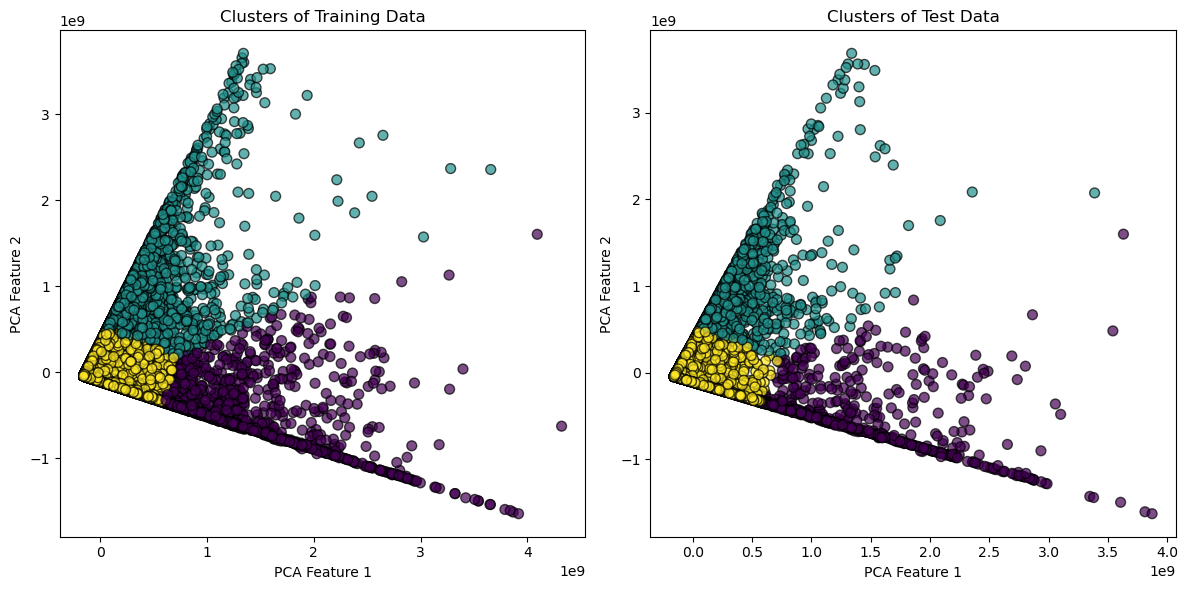

In [16]:


# Visualize the clusters
plt.figure(figsize=(12, 6))

# Plot training data
plt.subplot(1, 2, 1)
plt.scatter(trainX_pca[:, 0], trainX_pca[:, 1], c=pipeline.predict(trainX_pca), cmap='viridis', marker='o', edgecolor='k', s=50, alpha=0.7, label='Training Data')
plt.title('Clusters of Training Data')
plt.xlabel('PCA Feature 1')
plt.ylabel('PCA Feature 2')

# Plot test data
plt.subplot(1, 2, 2)
plt.scatter(testX_pca[:, 0], testX_pca[:, 1], c=y_pred_test, cmap='viridis', marker='o', edgecolor='k', s=50, alpha=0.7, label='Test Data')
plt.title('Clusters of Test Data')
plt.xlabel('PCA Feature 1')
plt.ylabel('PCA Feature 2')

plt.tight_layout()
plt.show()